In [42]:
import tensorflow as tf
print(tf.__version__)

import shutil
from tensorflow.contrib.learn import ModeKeys
import tensorflow.contrib.rnn as rnn

1.8.0


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil

In [48]:
SEQ_LEN = 10
def create_time_series():
  freq = (np.random.random()*0.5) + 0.1  # 0.1 to 0.6
  ampl = np.random.random() + 0.5  # 0.5 to 1.5
  x = np.sin(np.arange(0,SEQ_LEN) * freq) * ampl
  return x

/usr/local/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


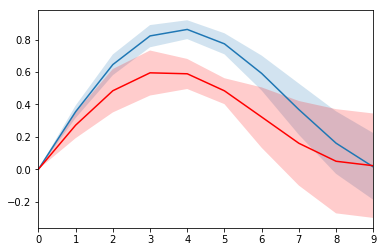

In [49]:
# Random examples
sns.tsplot([create_time_series() for i in range(20)])
sns.tsplot([create_time_series() for i in range(5)], color='red')

In [4]:
# Create training and testing data
train_df = pd.DataFrame(data=[create_time_series() for i in range(50000)])
test_df = pd.DataFrame(data=[create_time_series() for i in range(5000)])
train_df.to_csv("../data/algo_trading_fxcm/train.csv")
test_df.to_csv("../data/algo_trading_fxcm/test.csv")

#### Estimator in Tensorflow expects an `input_fn` to read the data, a function that returns `inputs` and `labels` rather than x and y. The `inputs` is a dictionary (name to tensor) and the `labels` is a tensor.

#### Reading in batches of `BATCH_SIZE = 20` lines at a time, specifying the data types for the tensors in `DEFAULTS`. `BATCH_SIZE` will have to be tuned properly

In [5]:
DEFAULTS = [[0.0] for x in range(SEQ_LEN)]
BATCH_SIZE = 20 # Read 20 lines at a time
TIMESERIES_COL = 'rawdata'
N_OUTPUTS = 2  # in each sequence, 1-8 are features, and 9-10 is label
N_INPUTS = SEQ_LEN - N_OUTPUTS

#### The Estimator API `input_fn` takes no parameters, so here we have a function `read_dataset` that can be used to specify files on the CLI.

In [44]:

# read data and convert to needed format
def read_dataset(filename, mode=ModeKeys.TRAIN):
  def _input_fn():
    num_epochs = 100 if mode == ModeKeys.TRAIN else 1
    
    # could be a path to one file or a file pattern.
    input_file_names = tf.train.match_filenames_once(filename)
    

    filename_queue = tf.train.string_input_producer(
        input_file_names, num_epochs=num_epochs, shuffle=True)
    reader = tf.TextLineReader()
    _, value = reader.read_up_to(filename_queue, num_records=BATCH_SIZE)

    value_column = tf.expand_dims(value, -1, name='value')
    print('readcsv={}'.format(value_column))
    
    # all_data is a list of tensors
    all_data = tf.decode_csv(value_column, record_defaults=DEFAULTS)  
    inputs = all_data[:len(all_data)-N_OUTPUTS]  # first few values
    label = all_data[len(all_data)-N_OUTPUTS : ] # last few values
    
    # from list of tensors to tensor with one more dimension
    inputs = tf.concat(inputs, axis=1)
    label = tf.concat(label, axis=1)
    print('inputs={}'.format(inputs))

    return {TIMESERIES_COL: inputs}, label   # dict of features, label

  return _input_fn

#### Define the RNN as Estimator does not come with an out-of-the-box RNN. It has LinearRegression, DNNLinearRegressor, DNNLinearCombinedRegressor, etc.

In [45]:
LSTM_SIZE = 3  # number of hidden layers in each of the LSTM cells

# create the inference model
def simple_rnn(features, labels, mode, params):
  # 0. Reformat input shape to become a sequence
  x = tf.split(features[TIMESERIES_COL], N_INPUTS, 1)
  #print 'x={}'.format(x)
    
  # 1. configure the RNN
  lstm_cell = rnn.BasicLSTMCell(LSTM_SIZE, forget_bias=1.0)
  outputs, _ = tf.nn.static_rnn(lstm_cell, x, dtype=tf.float32)

  # slice to keep only the last cell of the RNN
  outputs = outputs[-1]
  #print 'last outputs={}'.format(outputs)
  
  # output is result of linear activation of last layer of RNN
  weight = tf.Variable(tf.random_normal([LSTM_SIZE, N_OUTPUTS]))
  bias = tf.Variable(tf.random_normal([N_OUTPUTS]))
  predictions = tf.matmul(outputs, weight) + bias
    
  # 2. loss function, training/eval ops
  if mode == ModeKeys.TRAIN or mode == ModeKeys.EVAL:
     loss = tf.losses.mean_squared_error(labels, predictions)
     train_op = tf.contrib.layers.optimize_loss(
         loss=loss,
         global_step=tf.train.get_global_step(),
         learning_rate=0.01,
         optimizer="SGD")
     eval_metric_ops = {
      "rmse": tf.metrics.root_mean_squared_error(labels, predictions)
     }
  else:
     loss = None
     train_op = None
     eval_metric_ops = None
  
  # 3. Create predictions
  predictions_dict = {"predicted": predictions}

  # 4. Create export outputs  
  export_outputs = {"predicted": tf.estimator.export.PredictOutput(predictions)}

  # 5. return ModelFnOps
  return tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=predictions_dict,
      loss=loss,
      train_op=train_op,
      eval_metric_ops=eval_metric_ops,
      export_outputs=export_outputs)

<module 'tensorflow.contrib.learn' from '/usr/local/lib/python3.6/site-packages/tensorflow/contrib/learn/__init__.py'>

In [47]:

def get_train():
  return read_dataset('../data/algo_trading_fxcm/train.csv', mode=ModeKeys.TRAIN)

def get_valid():
  return read_dataset('../data/algo_trading_fxcm/test.csv', mode=ModeKeys.EVAL)

def serving_input_receiver_fn():
  feature_placeholders = {
    TIMESERIES_COL: tf.placeholder(tf.float32, [None, N_INPUTS])
  }

  features = {
    key: tf.expand_dims(tensor, -1)
    for key, tensor in feature_placeholders.items()
  }

  features[TIMESERIES_COL] = tf.squeeze(features[TIMESERIES_COL], axis=[2], name='timeseries')
  
  print('serving: features={}'.format(features[TIMESERIES_COL]))

  return tf.estimator.export.ServingInputReceiver(features, feature_placeholders)


def experiment_fn(output_dir):
  train_spec = tf.estimator.TrainSpec(input_fn=get_train(), max_steps=1000)
  exporter = tf.estimator.FinalExporter('timeseries',
    serving_input_receiver_fn)
  eval_spec = tf.estimator.EvalSpec(input_fn=get_valid(), 
    exporters=[exporter])

  estimator = tf.estimator.Estimator(model_fn=simple_rnn, model_dir=output_dir)

  tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

OUTPUT_DIR = 'outputdir'
shutil.rmtree(OUTPUT_DIR, ignore_errors=True) # start fresh each time

experiment_fn(OUTPUT_DIR)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'outputdir', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1288fb160>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after 600 secs (eval_spec.throttle_secs) or training is finished.
readcsv=Tensor("value:0", shape=(?, 1), dtype=string, device=/device:CPU:0)
inputs=Tensor("concat:0", shape=(?, 8), dtype=float32, device

InvalidArgumentError: Expect 10 fields but have 11 in record 0
	 [[Node: DecodeCSV = DecodeCSV[OUT_TYPE=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], field_delim=",", na_value="", use_quote_delim=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](value, DecodeCSV/record_defaults_0, DecodeCSV/record_defaults_0, DecodeCSV/record_defaults_0, DecodeCSV/record_defaults_0, DecodeCSV/record_defaults_0, DecodeCSV/record_defaults_0, DecodeCSV/record_defaults_0, DecodeCSV/record_defaults_0, DecodeCSV/record_defaults_0, DecodeCSV/record_defaults_0)]]

Caused by op 'DecodeCSV', defined at:
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/usr/local/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2909, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-47-d8ff4553caeb>", line 39, in <module>
    experiment_fn(OUTPUT_DIR)
  File "<ipython-input-47-d8ff4553caeb>", line 34, in experiment_fn
    tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/estimator/training.py", line 439, in train_and_evaluate
    executor.run()
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/estimator/training.py", line 518, in run
    self.run_local()
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/estimator/training.py", line 650, in run_local
    hooks=train_hooks)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/estimator/estimator.py", line 363, in train
    loss = self._train_model(input_fn, hooks, saving_listeners)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/estimator/estimator.py", line 843, in _train_model
    return self._train_model_default(input_fn, hooks, saving_listeners)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/estimator/estimator.py", line 853, in _train_model_default
    input_fn, model_fn_lib.ModeKeys.TRAIN))
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/estimator/estimator.py", line 691, in _get_features_and_labels_from_input_fn
    result = self._call_input_fn(input_fn, mode)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/estimator/estimator.py", line 798, in _call_input_fn
    return input_fn(**kwargs)
  File "<ipython-input-44-63a738474cec>", line 20, in _input_fn
    all_data = tf.decode_csv(value_column, record_defaults=DEFAULTS)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/parsing_ops.py", line 1215, in decode_csv
    name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gen_parsing_ops.py", line 68, in decode_csv
    na_value=na_value, name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Expect 10 fields but have 11 in record 0
	 [[Node: DecodeCSV = DecodeCSV[OUT_TYPE=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], field_delim=",", na_value="", use_quote_delim=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](value, DecodeCSV/record_defaults_0, DecodeCSV/record_defaults_0, DecodeCSV/record_defaults_0, DecodeCSV/record_defaults_0, DecodeCSV/record_defaults_0, DecodeCSV/record_defaults_0, DecodeCSV/record_defaults_0, DecodeCSV/record_defaults_0, DecodeCSV/record_defaults_0, DecodeCSV/record_defaults_0)]]
